# How to build a reliable, curated, and accurate RAG system using Cleanlab and Pinecone

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time
from IPython.display import display, HTML
import warnings
import matplotlib.pyplot as plt
import os
from pinecone import Pinecone, ServerlessSpec

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.environ["PINECONE_API_KEY"] = "b1ac813f-e461-44fc-a868-32a8d567a320"

In [3]:
api_key = os.environ.get("PINECONE_API_KEY")

# configure client
pc = Pinecone(api_key=api_key)

Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [4]:
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [5]:
class PineconeRAGPipeline:
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2', index_name='document-index', cloud='aws', region='us-east-1'):
        self.model = SentenceTransformer(model_name)
        self.pc = Pinecone(api_key=os.environ.get('PINECONE_API_KEY'))
        self.index_name = index_name
        
        # Check if the index already exists
        existing_indexes = self.pc.list_indexes()
        
        if self.index_name not in existing_indexes:
            try:
                print(f"Creating new index: {self.index_name}")
                self.pc.create_index(
                    name=self.index_name,
                    dimension=self.model.get_sentence_embedding_dimension(),
                    metric='cosine',
                    spec=ServerlessSpec(cloud=cloud, region=region)
                )
            except Exception as e:
                if "ALREADY_EXISTS" in str(e):
                    print(f"Index {self.index_name} already exists. Connecting to existing index.")
                else:
                    raise e
        else:
            print(f"Index {self.index_name} already exists. Connecting to existing index.")
        
        # Connect to the index
        self.index = self.pc.Index(self.index_name)

    def index_documents(self, df):
        """
        Index documents from a DataFrame with specific metadata structure.
        
        :param df: DataFrame containing document information and metadata.
        """
        valid_docs = []
        valid_metadata = []

        for _, row in df.iterrows():
            if pd.isna(row['text']) or pd.isna(row['filename']) or pd.isna(row['topic']):
                print(f"Skipping invalid document: {row['filename']}")
                continue
            
            # doc = str(row['text'])[:5000]  # Limit to 5000 characters
                        
            doc = str(row['text'])
            metadata = {
                'filename': row['filename'],
                'topic': row['topic'],
                'quality': row['quality'] if not pd.isna(row['quality']) else 'unknown'
            }
            
            valid_docs.append(doc)
            valid_metadata.append(metadata)

        if not valid_docs:
            print("No valid documents to index.")
            return

        doc_embeddings = self.model.encode(valid_docs)
        
        batch_size = 100  # Adjust this based on your needs
        for i in range(0, len(valid_docs), batch_size):
            batch_docs = valid_docs[i:i+batch_size]
            batch_metadata = valid_metadata[i:i+batch_size]
            batch_embeddings = doc_embeddings[i:i+batch_size]
            
            vectors = [
                (f'doc_{i+j}', embedding.tolist(), {**metadata, 'text': doc[:1000]})
                for j, (doc, embedding, metadata) in enumerate(zip(batch_docs, batch_embeddings, batch_metadata))
            ]
            
            try:
                self.index.upsert(vectors=vectors)
                print(f"Successfully indexed batch of {len(vectors)} documents.")
            except Exception as e:
                print(f"Error during upsert: {e}")

    def search(self, query, top_k=5, filter_query=None):
        """
        Search for the top_k most relevant documents based on the input query and optional filter.
        
        :param query: The search query text.
        :param top_k: The number of top relevant documents to return.
        :param filter_query: Optional filter query to apply during search.
        :return: List of top_k relevant document texts and their metadata.
        """
        query_embedding = self.model.encode(query)
        
        try:
            results = self.index.query(
                vector=query_embedding.tolist(),
                top_k=top_k,
                filter=filter_query,
                include_metadata=True
            )
            
            return [(match.metadata['text'], {k: v for k, v in match.metadata.items() if k != 'text'}) for match in results.matches]
        except Exception as e:
            print(f"Error during search: {e}")
            return []

    def delete_index(self):
        """
        Delete the Pinecone index.
        """
        try:
            self.pc.delete_index(self.index_name)
            print(f"Index '{self.index_name}' has been deleted.")
        except Exception as e:
            print(f"Error deleting index: {e}")

## Load Documents Data

In [6]:
# Read in dataset
df = pd.read_csv("document-curation-RAG.csv")
print(df.shape)

document_data_columns = list(df.columns)
print(f"The columns in our documents data are: {document_data_columns}")

(139, 5)
The columns in our documents data are: ['index', 'filename', 'topic', 'quality', 'text']


## Analyze Documents Data

Summary Statistics of Text Length:
count       139.00000
mean       9474.00000
std       18093.41533
min           0.00000
25%        1776.50000
50%        3727.00000
75%        8104.00000
max      143918.00000
Name: text_length, dtype: float64


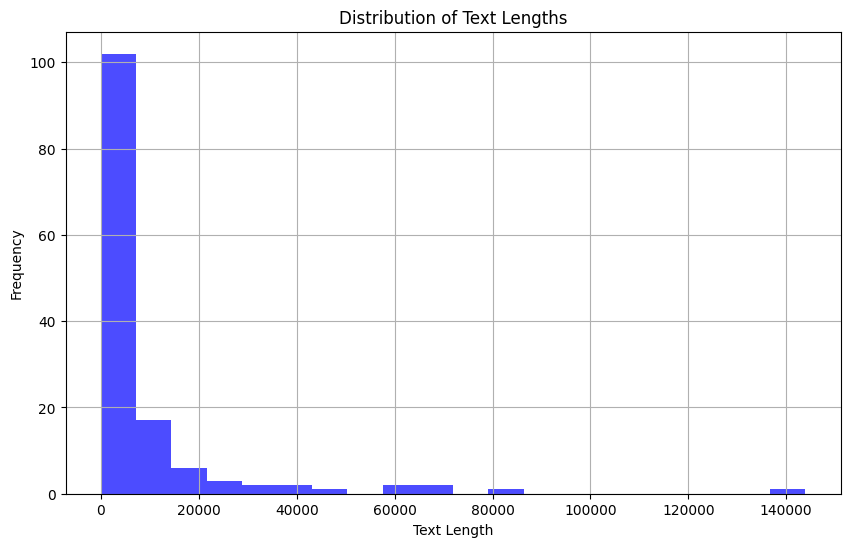

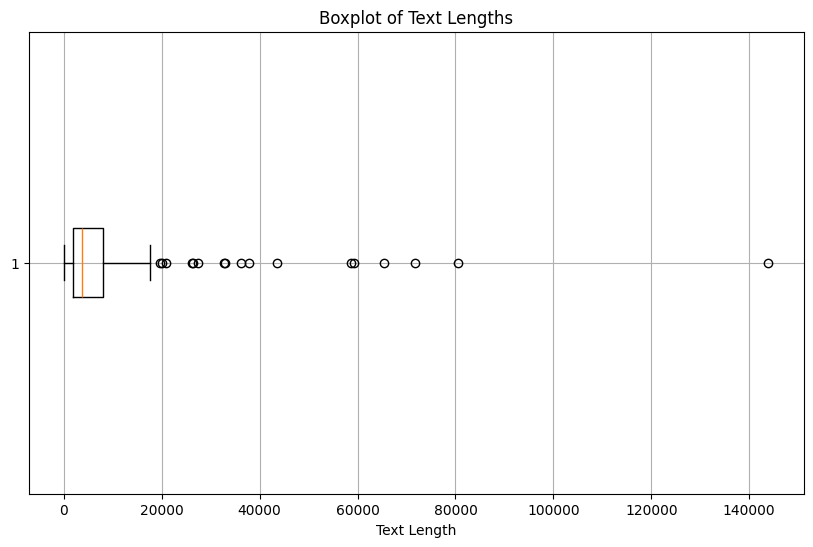

In [7]:
# Calculate the length of the text in the 'text' column
df['text_length'] = df['text'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Summary statistics
length_stats = df['text_length'].describe()
print("Summary Statistics of Text Length:")
print(length_stats)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Optional: plot a boxplot to see the distribution with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['text_length'], vert=False)
plt.title('Boxplot of Text Lengths')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()

In [8]:
# Analyze missing values
missing_values = df.isnull().sum()
print(f"\nMissing Values in Each Column:\n{missing_values}")

# Analyze the 'quality' column
quality_counts = df['quality'].value_counts(dropna=False)
print(f"\nQuality Column Distribution:\n{quality_counts}")

# Quality distribution per topic
quality_topic_distribution = df.pivot_table(index='topic', columns='quality', aggfunc='size', fill_value=0)
print(f"\nQuality Distribution per Topic:\n{quality_topic_distribution}")


Missing Values in Each Column:
index            0
filename         0
topic            0
quality        103
text             3
text_length      0
dtype: int64

Quality Column Distribution:
quality
NaN     103
good     18
bad      18
Name: count, dtype: int64

Quality Distribution per Topic:
quality  bad  good
topic             
finance    2     6
hr         2     5
it         9     1
product    2     3
sales      3     3


## Use Cleanlab Studio to ensure there is no PII, duplicates, non-English text, or toxic language in our documents

In [9]:
from cleanlab_studio import Studio

API_KEY = "f4e6c1d95ec24abf8607af073128c192"
studio = Studio(API_KEY)

### Ingest our documents data into Cleanlab Studio

In [23]:
dataset_id = studio.upload_dataset(
    df,
    dataset_name="cleanlab_pinecone_RAG_documents"
)
print(f"Dataset ID: {dataset_id}")

Uploading dataset...: 100%|████████████████████████████████████████████████████████████████████████████████████████████|
Ingesting Dataset...: 100%|████████████████████████████████████████████████████████████████████████████████████████████|

Dataset ID: 39ebcf90203143e7aee5d1543efa3579


### Launch a Cleanlab Studio Project using our documents data to analyze the text

In [16]:
text_column = "text"

In [25]:
project_id = studio.create_project(
    dataset_id=dataset_id,
    project_name="Cleanlab Pinecone RAG Documents Project",
    modality="text",
    task_type="unsupervised",
    model_type="regular",  # text issue detection is currently only available in Regular mode
    label_column=None,
    text_column=text_column
)
print(f"Project successfully created and training has begun! project_id: {project_id}")

Project successfully created and training has begun! project_id: acda265579014b96b5e554c4eea587ae


In [26]:
cleanset_id = studio.get_latest_cleanset_id(project_id)
project_status = studio.wait_until_cleanset_ready(cleanset_id)

Cleanset Progress: \ Step 25/25, Ready for review!


In [12]:
# Download cleanlab columns from text project
cleanlab_columns = studio.download_cleanlab_columns(cleanset_id)

In [13]:
print(cleanlab_columns.columns)

Index(['cleanlab_row_ID', 'is_near_duplicate', 'near_duplicate_score',
       'near_duplicate_cluster_id', 'is_outlier', 'outlier_score',
       'is_empty_text', 'text_num_characters', 'is_PII', 'PII_score',
       'PII_types', 'PII_items', 'is_informal', 'informal_score',
       'spelling_issue_score', 'grammar_issue_score', 'slang_issue_score',
       'is_non_english', 'non_english_score', 'predicted_language', 'is_toxic',
       'toxic_score', 'sentiment_score', 'bias_score', 'is_biased',
       'gender_bias_score', 'racial_bias_score',
       'sexual_orientation_bias_score'],
      dtype='object')


## Check for issues detected by Cleanlab Studio in our documents data

In [17]:
# Combine DataFrame with Cleanlab columns
cleanlab_df = df.merge(
    cleanlab_columns, left_index=True, right_index=True
)

display(cleanlab_df.head())

,index,filename,topic,quality,text,text_length,cleanlab_row_ID,is_near_duplicate,near_duplicate_score,near_duplicate_cluster_id,...,non_english_score,predicted_language,is_toxic,toxic_score,sentiment_score,bias_score,is_biased,gender_bias_score,racial_bias_score,sexual_orientation_bias_score
0,1,documents/Blackstone-Third-Quarter-2023-Invest...,finance,good,Blackstone Third Quarter 2023 Investor Call Oc...,59328,1,False,0.369557,<NA>,...,0.039626,<NA>,False,0.181357,0.734437,0.231685,False,0.0,0.231685,0.000024
1,2,documents/8k-nike.pdf,finance,good,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...,32855,2,False,0.366482,<NA>,...,0.559182,<NA>,False,0.131032,0.663306,0.236311,False,0.0,0.236311,0.000080
2,3,documents/04-FY24-Q1-NIKE-Press-Release.pdf,finance,good,Investor Contact:Media Contact:Paul TrussellVi...,12599,3,False,0.296951,<NA>,...,0.073851,<NA>,False,0.174005,0.624429,0.252296,False,0.0,0.252296,0.000005
3,4,documents/10-K 2022-Apple2.pdf,finance,good,The future principal payments for the Company’...,7346,4,False,0.558332,<NA>,...,0.074378,<NA>,False,0.082228,0.722761,0.246289,False,0.0,0.246289,0.001359
4,5,documents/q3-fy22-earnings-presentation.pdf,finance,NaN,Financial\tpresentation\tto\t accompany\tmanag...,37757,5,False,0.567074,<NA>,...,0.081154,<NA>,False,0.135358,0.675202,0.227926,False,0.0,0.227926,0.000001


In [18]:
outlier_issues = cleanlab_df.query("is_outlier").sort_values("outlier_score", ascending=False)

outlier_columns = ["outlier_score", "is_outlier"]
columns_to_display = [text_column] + outlier_columns

print(f"There are {len(outlier_issues)} outliers in our documents data.")
display(outlier_issues.head(5)[columns_to_display])

There are 0 outliers in our documents data.


,text,outlier_score,is_outlier


In [19]:
near_duplicates = cleanlab_df.query("is_near_duplicate").sort_values(by=["near_duplicate_cluster_id", "near_duplicate_score"])

near_duplicate_columns = ["near_duplicate_score", "near_duplicate_cluster_id", "is_near_duplicate"]
columns_to_display = [text_column] + near_duplicate_columns

print(f"There are {len(near_duplicates)} near (or exact) duplicates in our documents data. Here are some examples below:\n")
display(near_duplicates.head()[columns_to_display])

There are 25 near (or exact) duplicates in our documents data. Here are some examples below:



,text,near_duplicate_score,near_duplicate_cluster_id,is_near_duplicate
43,NaN,1.000000,0,True
44,NaN,1.000000,0,True
88,NaN,1.000000,0,True
96,[OUTDATED] Product Name Description Price Avai...,0.977763,1,True
119,Product Name Description Price Availability Sm...,0.977763,1,True


In [20]:
pii_issues = cleanlab_df.query("is_PII").sort_values("PII_score", ascending=False)

pii_columns = ["PII_items", "PII_types", "PII_score", "is_PII"]
columns_to_display = [text_column] + pii_columns

print(f"There are {len(pii_issues)} PII issues in our documents data. Here are some examples below:\n")
display(pii_issues.head(5)[columns_to_display])

There are 55 PII issues in our documents data. Here are some examples below:



,text,PII_items,PII_types,PII_score,is_PII
1,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...,"[""www.secdatabase.com."", ""www.secdatabase.com....","[""Twitter username"", ""URL"", ""Uncategorized PII...",0.5,True
95,AquaFarm sales call with Beetary Personal Memo...,"[""johnson.jacobs@gmail.com""]","[""email""]",0.5,True
2,Investor Contact:Media Contact:Paul TrussellVi...,"[""Rustique-Petteniinvestor.relatio"", ""https://...","[""Twitter username"", ""URL"", ""email"", ""phone nu...",0.5,True
53,Internet and Technology Safety Policy Agreemen...,"[""davidbrown@gmail.com""]","[""email""]",0.5,True
54,Grade Level/Dept StaffYes Cost: ______________...,"[""Jones01/01/24sjones@gmail.com561"", ""89109555...","[""email""]",0.5,True


In [21]:
informal_issues = cleanlab_df.query("is_informal").sort_values("informal_score", ascending=False)

informal_columns = ["informal_score", "is_informal", 'spelling_issue_score', 'grammar_issue_score', 'slang_issue_score']
columns_to_display = [text_column] + informal_columns

print(f"There are {len(informal_issues)} informal issues in our documents data. Here are some examples below:\n")
display(informal_issues.head(5)[columns_to_display])

There are 40 informal issues in our documents data. Here are some examples below:



,text,informal_score,is_informal,spelling_issue_score,grammar_issue_score,slang_issue_score
97,Ð​Ð³Ñ€Ð¾Ð˜Ð½Ð½Ð¾Ð²ÐµÐ¹Ñ‚: ÐŸÑ€Ð¸Ð²Ð»ÐµÑ‡ÐµÐ½Ð¸...,0.706596,True,0.942308,0.405155,0.890181
100,Kundenansprache\tfÃ¼r\tDataWaveEinfÃ¼hrungData...,0.702962,True,0.720379,0.688940,0.708276
62,ModelMaterialPanel SizeFolded SizeHeightWeight...,0.682100,True,0.729167,0.563636,0.777031
4,Financial\tpresentation\tto\t accompany\tmanag...,0.676962,True,0.202083,0.855214,0.736149
101,Kundenaufbaustrategie\tfÃ¼r\tBrewMastersGuildE...,0.671138,True,0.717300,0.607131,0.712065


In [23]:
biased_issues = cleanlab_df.query("is_biased").sort_values("bias_score", ascending=False)

biased_columns = ["bias_score", "is_biased", 'gender_bias_score', 'racial_bias_score', 'sexual_orientation_bias_score']
columns_to_display = [text_column] + biased_columns

print(f"There are {len(biased_issues)} biased issues in our documents data.")
display(biased_issues.head(5)[columns_to_display])

There are 0 biased issues in our documents data.


,text,bias_score,is_biased,gender_bias_score,racial_bias_score,sexual_orientation_bias_score


In [24]:
toxic_issues = cleanlab_df.query("is_toxic").sort_values("toxic_score", ascending=False)

toxic_columns = ['is_toxic', 'toxic_score']
columns_to_display = [text_column] + toxic_columns

print(f"There are {len(toxic_issues)} toxic issues in our documents data. Here are some examples below:\n")
display(toxic_issues.head(5)[columns_to_display])

There are 3 toxic issues in our documents data. Here are some examples below:



,text,is_toxic,toxic_score
94,YOU ARE A HORRIBLE CFO why in the world would ...,True,0.862793
84,"To the HR Department,GO DIE!It's become increa...",True,0.834473
85,"Today's meeting was heated, to say the least. ...",True,0.831543


In [25]:
non_english_issues = cleanlab_df.query("is_non_english").sort_values("non_english_score", ascending=False)

non_english_columns = ['is_non_english', 'non_english_score', 'predicted_language']
columns_to_display = [text_column] + non_english_columns

print(f"There are {len(non_english_issues)} non English issues in our documents data. Here are some examples below:\n")
display(non_english_issues.head(5)[columns_to_display])

There are 6 non English issues in our documents data. Here are some examples below:



,text,is_non_english,non_english_score,predicted_language
43,NaN,True,0.984444,<NA>
44,NaN,True,0.984444,<NA>
88,NaN,True,0.984444,<NA>
97,Ð​Ð³Ñ€Ð¾Ð˜Ð½Ð½Ð¾Ð²ÐµÐ¹Ñ‚: ÐŸÑ€Ð¸Ð²Ð»ÐµÑ‡ÐµÐ½Ð¸...,True,0.971142,<NA>
100,Kundenansprache\tfÃ¼r\tDataWaveEinfÃ¼hrungData...,True,0.915949,German


In [67]:
# Create a list of columns that start with "is_"
is_columns = [col for col in cleanlab_df.columns if col.startswith('is_')]

# Filter out rows where any of the "is_" columns have a value of True or 1
filtered_df = cleanlab_df[~cleanlab_df[is_columns].any(axis=1)]

In [27]:
is_columns

['is_near_duplicate',
 'is_outlier',
 'is_empty_text',
 'is_PII',
 'is_informal',
 'is_non_english',
 'is_toxic',
 'is_biased']

In [35]:
filtered_df = filtered_df[document_data_columns]

Summary Statistics of Text Length:
count       41.000000
mean      9723.414634
std      16410.582474
min        210.000000
25%       1574.000000
50%       3510.000000
75%       7346.000000
max      71817.000000
Name: text_length, dtype: float64


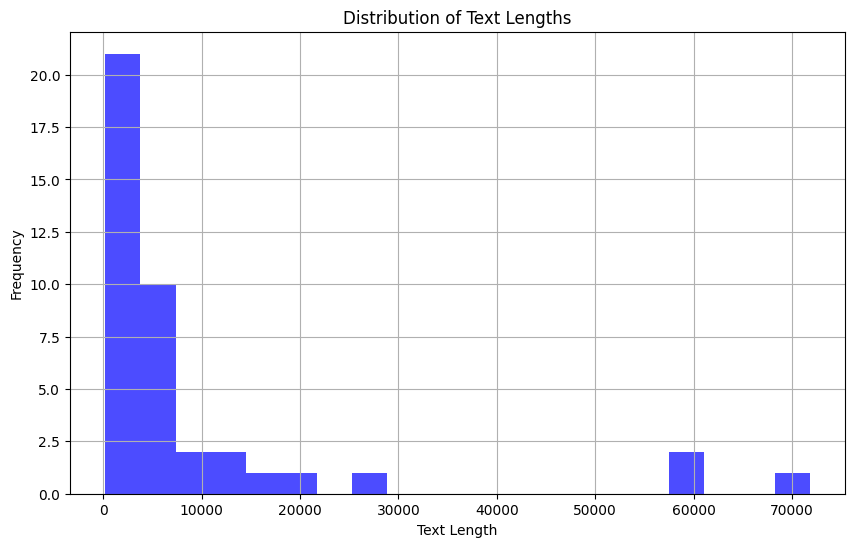

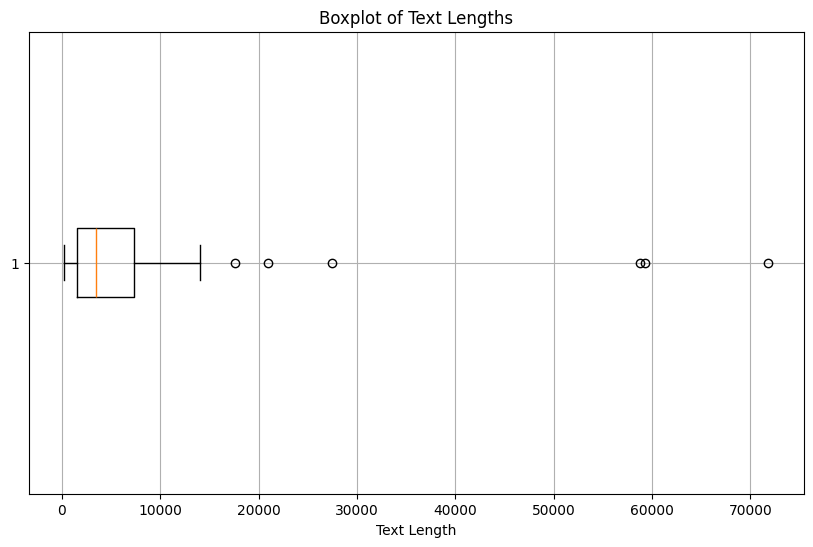

In [36]:
# Calculate the length of the text in the 'text' column
filtered_df['text_length'] = filtered_df['text'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Summary statistics
length_stats = filtered_df['text_length'].describe()
print("Summary Statistics of Text Length:")
print(length_stats)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['text_length'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Optional: plot a boxplot to see the distribution with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_df['text_length'], vert=False)
plt.title('Boxplot of Text Lengths')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()



In [37]:
# Analyze missing values
missing_values = filtered_df.isnull().sum()
print(f"\nMissing Values in Each Column:\n{missing_values}")

# Analyze the 'quality' column
quality_counts = filtered_df['quality'].value_counts(dropna=False)
print(f"\nQuality Column Distribution:\n{quality_counts}")

# Quality distribution per topic
quality_topic_distribution = filtered_df.pivot_table(index='topic', columns='quality', aggfunc='size', fill_value=0)
print(f"\nQuality Distribution per Topic:\n{quality_topic_distribution}")


Missing Values in Each Column:
index           0
filename        0
topic           0
quality        29
text            0
text_length     0
dtype: int64

Quality Column Distribution:
quality
NaN     29
good    10
bad      2
Name: count, dtype: int64

Quality Distribution per Topic:
quality  bad  good
topic             
finance    0     3
hr         0     2
it         2     0
product    0     3
sales      0     2


## Initialize RAG Pipeline

In [38]:
# Intialize RAG pipeline
rag_pipeline = PineconeRAGPipeline()
rag_pipeline.index_documents(filtered_df)

Creating new index: document-index
Index document-index already exists. Connecting to existing index.
Successfully indexed batch of 41 documents.


In [39]:
filtered_df.query("topic=='finance' and quality=='good'")

,index,filename,topic,quality,text,text_length
0,1,documents/Blackstone-Third-Quarter-2023-Invest...,finance,good,Blackstone Third Quarter 2023 Investor Call Oc...,59328
3,4,documents/10-K 2022-Apple2.pdf,finance,good,The future principal payments for the Company’...,7346
19,24,documents/Authorization_for_Direct_Deposit_IFS...,finance,good,Intuit Full Service Payroll . . . . . . . . . ...,1684


## Search for documents with topic = finance and quality = good

In [40]:
results = rag_pipeline.search(
    query="Your search query",
    top_k=2,
    filter_query={
        "topic": {"$eq": "finance"},
        "quality": {"$eq": "good"}
    }
)

for doc_text, metadata in results:
    print(f"Document: {doc_text[:100]}...")
    print(f"Metadata: {metadata}")
    print("---")

Document: Intuit Full Service Payroll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Metadata: {'filename': 'documents/Authorization_for_Direct_Deposit_IFSP.pdf', 'quality': 'good', 'topic': 'finance'}
---
Document: Blackstone Third Quarter 2023 Investor Call October 19, 2023 at 9:00am ETModerator: Good day and wel...
Metadata: {'filename': 'documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf', 'quality': 'good', 'topic': 'finance'}
---


### View Retreived Document

In [50]:
# Simple query regarding our documents
question = "Tell me about the sales principles at SAP Business One"

top_doc = rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "sales"}})
print(f"Top doc for this query: \n\n{top_doc[0]}")

Top doc for this query: 

('Welcome to the topic on the sales process.In this topic, we will examine the basic steps in the sales process in SAP Business One. Then we will perform a streamlined sales process.2Imagine that your company has set customer satisfaction as its top priority. You review the basic steps in the sales process and decide to use a streamlined process for rush orders to ensure that customer demands can be met as quickly as possible.3(cid:132) The sales-A/R process moves from selling the goods (and services) to delivering those goods to invoicing the customer for their purchases, to the last step in accounting of receiving the incoming payment.(cid:132) Each step in the sales process involves a document, such as a sales order, delivery, or A/R invoice. SAP Business One efficiently moves all relevant information from one document to the next in the document flow. According to the business needs, you can choose which documents to include as your process steps. The only

## Use TLM to get Trustworthiness Score for RAG Outputs

### Build the Prompt and Query TLM

In [55]:
rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "sales"}})[0][0]

'Welcome to the topic on the sales process.In this topic, we will examine the basic steps in the sales process in SAP Business One. Then we will perform a streamlined sales process.2Imagine that your company has set customer satisfaction as its top priority. You review the basic steps in the sales process and decide to use a streamlined process for rush orders to ensure that customer demands can be met as quickly as possible.3(cid:132) The sales-A/R process moves from selling the goods (and services) to delivering those goods to invoicing the customer for their purchases, to the last step in accounting of receiving the incoming payment.(cid:132) Each step in the sales process involves a document, such as a sales order, delivery, or A/R invoice. SAP Business One efficiently moves all relevant information from one document to the next in the document flow. According to the business needs, you can choose which documents to include as your process steps. The only mandatory document in sale

In [59]:
question = "Based on the sales principles at SAP Business One, where is item information stored?"
top_docs = "".join(rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "sales"}})[0][0])


prompt = f"Based on the following documents, answer the given question. \n\
Documents: {top_docs} \n\
Question: {question}"

tlm = studio.TLM(quality_preset="low",)
output = tlm.prompt(prompt)
output

{'response': 'In SAP Business One, item information is typically stored in the Item Master Data. This central repository contains detailed information about each item, including descriptions, pricing, inventory levels, and other relevant attributes. This data is utilized throughout the sales process, from creating sales orders to invoicing and delivery.',
 'trustworthiness_score': 0.8826425114150929}

### Is the correct?

In [57]:
top_docs[3063:3140]

''

In [66]:
rag_pipeline.search(question, top_k=2, filter_query={"topic": {"$eq": "sales"}})

[('Welcome to the topic on the sales process.In this topic, we will examine the basic steps in the sales process in SAP Business One. Then we will perform a streamlined sales process.2Imagine that your company has set customer satisfaction as its top priority. You review the basic steps in the sales process and decide to use a streamlined process for rush orders to ensure that customer demands can be met as quickly as possible.3(cid:132) The sales-A/R process moves from selling the goods (and services) to delivering those goods to invoicing the customer for their purchases, to the last step in accounting of receiving the incoming payment.(cid:132) Each step in the sales process involves a document, such as a sales order, delivery, or A/R invoice. SAP Business One efficiently moves all relevant information from one document to the next in the document flow. According to the business needs, you can choose which documents to include as your process steps. The only mandatory document in sa

In [64]:
question = "Based on the sales principles at SAP Business One, where is item information stored?"
"".join(rag_pipeline.search(question, top_k=2, filter_query={"topic": {"$eq": "sales"}})[0])


TypeError: sequence item 1: expected str instance, dict found

In [ ]:
### find something in pinecone more accurate than handpicking the topic

### use pinecone to make RAG demo more realistic 

### Can we find a hallucination?

In [99]:
question = "Does the TurboCharge EV6000 support the UL/CE/ISO charger protocols?"
top_docs = " | ".join(rag_pipeline.search(question, top_k=1, topic='product'))

prompt = f"Based on the following documents, answer the given question. \n\
Documents: {top_docs} \n\
Question: {question}"

tlm = studio.TLM(quality_preset="low",)
output = tlm.prompt(prompt)
output

{'response': 'The given documents do not provide any information about whether the TurboCharge EV6000 supports the UL/CE/ISO charger protocols.',
 'trustworthiness_score': 0.6223180925974554}

### Is the correct?

In [11]:
top_docs[2239:2300]

'Charging Standards CHAdeMO, CCS, Tesla Supercharger Supported'

### Apply TLM to Existing RAG Pipeline or any LLM

In [12]:
prompt = "Based on the following documents, answer the given question. \n\
Documents:  We're getting new desks! Specs are here: Staples Model RTG120XLDBL BasePage \
CollectionModel | Dimensions width = 60.0in height = 48.0in depth = 24.0in Base Color Black \
Top Color White | Specs SheetsPowered by TCPDF (www.tcpdf.org)\
Question: What is the width of the new desks?"

response_A = "60 inches"
response_B = "24 inches" 

trust_score_A = tlm.get_trustworthiness_score(prompt, response_A)
trust_score_B = tlm.get_trustworthiness_score(prompt, response_B)

print(f"TLM Score for Response A: {trust_score_A}")
print(f"TLM Score for Response B: {trust_score_B}")

TLM Score for Response A: 0.8407435458726287
TLM Score for Response B: 0.2884272564664554


In [247]:
class RAGPipeline:
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
        self.documents = []
        self.embeddings = []
        self.topics = []

    def index_documents(self, docs, topics):
        """
        Index a list of documents by generating their embeddings and storing topics.
        
        :param docs: List of document texts to be indexed.
        :param topics: List of topic labels corresponding to each document.
        """
        self.documents.extend(docs)
        self.topics.extend(topics)
        doc_embeddings = self.model.encode(docs, convert_to_tensor=True)
        self.embeddings.extend(doc_embeddings)

    def search(self, query, top_k=5, topic=None):
        """
        Search for the top_k most relevant documents based on the input query and optional topic.
        
        :param query: The search query text.
        :param top_k: The number of top relevant documents to return.
        :param topic: Optional topic label to filter documents.
        :return: List of top_k relevant document texts.
        """
        query_embedding = self.model.encode(query, convert_to_tensor=True)

        if topic:
            filtered_indices = [i for i, t in enumerate(self.topics) if t == topic]
            filtered_embeddings = [self.embeddings[i] for i in filtered_indices]
            filtered_docs = [self.documents[i] for i in filtered_indices]
        else:
            filtered_embeddings = self.embeddings
            filtered_docs = self.documents

        cos_similarities = cosine_similarity(
            query_embedding.cpu().numpy().reshape(1, -1),
            np.array([embedding.cpu().numpy() for embedding in filtered_embeddings])
        ).flatten()

        top_indices = np.argsort(-cos_similarities)[:top_k]
        return [filtered_docs[idx] for idx in top_indices]

In [ ]:
# Add link to Llama index tutorial